# EpiRC-PGSの実装

[Near-Optimal Policy Identification in Robust Constrained Markov Decision Processes via Epigraph Form](https://openreview.net/forum?id=G5sPv4KSjR)において提案された，**Epigraph Robust Constrained Policy Gradient Search**(EpiRC-PGS)の再現実装を行いました．

* ほとんど自力で作ったので，ひどいコードです．
* 外側ループの二分探索は正しいと思います．
* 内側ループの勾配収束が現状の問題です．
  * 内側ループ内の反復で方策がすぐに決定論的になってしまって，勾配が収束しない問題が発生しているっぽいです．直したいです．
* numpyで実装したので反復計算が結構遅いです．jaxで描いたほうがいいかも
* コメントは適宜改良します．




In [6]:
import random
from jax import grad
import numpy as np

S = 3 # 状態数
A = 2 # 行動数
N = 4  # 制約+目的関数の数
T = 100  # エピソード数
U_num = 3 # 不確実性集合の要素数
alpha = 0.01  # 学習率
gamma = 0.95 # 割引率

# 方策の初期化
# pi は S*A の1次元ベクトルとして初期化(論文上でベクトルだけど，コードなら行列にしたほうが良かった気がする)
pi = np.zeros((S, A)) 
pi_temp_table = np.random.rand(S, A)
pi_temp_table = pi_temp_table / np.sum(pi_temp_table, axis=1, keepdims=True)
pi = pi_temp_table.flatten() # グローバル変数 pi (1次元 S*A ベクトル)

# 初期状態分布 mu の初期化
# mu は S 次元のベクトルとして初期化
mu = np.random.rand(S)
mu = mu / np.sum(mu) 

# 有効ホライゾンの定義
H = int(np.round(1 / (1 - gamma)))

# ==== metrics buffer ====
outer_hist = {
    "iter": [], "i": [], "j": [], "B0": [], "delta": [], "width": [],
    "worst_n": [], "worst_u": [], "J_max": [], "grad_norm": [],
}

# 方策の推移（各 outer 反復の最後の π を保存）
policy_hist = []   # list of (S*A,) 1D arrays



# 不確実性集合の作成
def make_U():
    U_list = []
    for _ in range(U_num):
        P_kernel = np.random.rand(S, A, S)
        P_kernel = P_kernel / np.sum(P_kernel, axis=2, keepdims=True)
        U_list.append(P_kernel)
    return U_list

U = make_U() 

# N個(制約数個)のコスト関数、初期化されたQ行列、閾値を作成
def make_C_and_Q_pi_b():
    C_list = []
    Q_list = [] 
    B_list = []
    for _ in range(N): 
        c_sa = np.random.rand(S, A)
        C_list.append(c_sa)
        Q_pi_initial = np.zeros((S, A)) 
        Q_list.append(Q_pi_initial)
        b_val = random.randint(0, H)
        B_list.append(b_val)
    return C_list, Q_list, B_list

C, Q_initial_list, B = make_C_and_Q_pi_b() 
                                       


def compute_dot_pi_Q(s_idx, current_Q_sa,pi): 
    """
    方策 pi と Q 関数の内積を計算
    pi は S*A の1次元ベクトルとして与えられ、Qは S*A の2次元行列として与えられる。
    input:
    s_idx: 状態のインデックス (0 <= s_idx < S)
    current_Q_sa: Q関数の行列 (S, A)
    pi: 方策の1次元ベクトル (S*A)
    output:
    V_s: 状態 s の価値関数 V(s) の値
    """

    pi_s_actions = pi[s_idx * A : (s_idx + 1) * A] #s_idx行における行動列ベクトルの獲得．次元は A
    return np.dot(pi_s_actions, current_Q_sa[s_idx, :])# Q行列のs_idx行と行動列ベクトルの内積を計算．スカラー値

def compute_sum_dot_pi_Q(current_Q_sa,pi): 
    """
    全てのsについて方策とQ関数の内積を計算した配列
    
    input:
    current_Q_sa: Q関数の行列 (S, A)
    pi: 方策の1次元ベクトル (S*A)
    output:
    V_s_results: 各状態 s の価値関数 V(s) の値を格納した配列 (S,)
    """

    V_s_results = np.zeros(S) # 出力用S次元のベクトルを初期化
    for s_idx in range(S): 
        V_s_results[s_idx] = compute_dot_pi_Q(s_idx, current_Q_sa,pi) # Q行列のs_idx行と方策ののs_idx行動列ベクトルの内積を計算し，s_idx行に格納
    return V_s_results # 各状態 s の価値関数V(s)の値を格納した配列．次元はS

def compute_sum_P_dot_dot_pi_Q(s_idx, a_idx, P_kernel_sas, current_Q_sa,pi):
    """
    sum_{s'} P(s'|s,a) V(s') を計算
    input:
        s_idx: 状態のインデックス (0 <= s_idx < S)
        a_idx: 行動のインデックス (0 <= a_idx < A)
        P_kernel_sas: 状態遷移確率行列 (S, A, S')
        current_Q_sa: Q関数の行列 (S, A)
        pi: 方策の1次元ベクトル (S*A)
    output:
        sum_{s'} P(s'|s,a) V(s')，スカラー
    """
    V_s_prime_current = compute_sum_dot_pi_Q(current_Q_sa,pi) # Vを計算
    return np.dot(P_kernel_sas[s_idx, a_idx, :], V_s_prime_current)#VとPの内積をとる．

def compute_Q_pi_c_P(s_idx, a_idx, P_kernel_sas, current_Q_sa, cost_sa_current,pi):
    """
    Q(s,a) の1ステップ更新値を計算します(ベルマン方程式の適用)

    Q^\pi_c_P(s,a) = c(s,a) + gamma * sum_{s'} P(s'|s,a) V(s')

    input:
        s_idx: 状態のインデックス (0 <= s_idx < S)
        a_idx: 行動のインデックス (0 <= a_idx < A)
        P_kernel_sas: 状態遷移確率行列 (S, A, S')
        current_Q_sa: Q関数の行列 (S, A)
        cost_sa_current: コスト関数 (S, A)
        pi: 方策の1次元ベクトル (S*A)
    output:
        Q(s,a) の1ステップ更新値，スカラー
    """
    expected_future_val = compute_sum_P_dot_dot_pi_Q(s_idx, a_idx, P_kernel_sas, current_Q_sa,pi)
    return cost_sa_current[s_idx, a_idx] + gamma * expected_future_val

def compute_Q_pi_c_P_matrix(P_kernel_sas, Q_sa_initial_guess, cost_sa_current,pi, max_iterations=1000,tolerance=0.001):
    """
    Q関数の行列を反復計算します．ベルマン方程式を更新誤差が収束するまで反復的に計算します．
    input:
        P_kernel_sas: 状態遷移確率行列 (S, A, S')
        Q_sa_initial_guess: Q関数の初期値 (S, A)
        cost_sa_current: コスト関数 (S, A)
        pi: 方策の1次元ベクトル (S*A)
        max_iterations: 最大反復回数
        tolerance: 収束判定の閾値
    output:
        Q_k_plus_1_sa: 収束したQ関数の行列 (S, A)
    """
    Q_k_sa = np.copy(Q_sa_initial_guess)

    
    # ベルマン方程式で更新されたQを反復的にベルマン方程式を適用して計算
    for iteration in range(max_iterations):
        Q_k_plus_1_sa = np.zeros((S, A)) 
        # Qの行列全てに対してベルマン方程式を適用
        for s_idx in range(S):
            for a_idx in range(A):
                Q_k_plus_1_sa[s_idx, a_idx] = compute_Q_pi_c_P( # 元の compute_Q_pi_c_P を呼び出し
                    s_idx, a_idx, P_kernel_sas, Q_k_sa, cost_sa_current,pi
                )
        
        # 収束判定
        if np.max(np.abs(Q_k_plus_1_sa - Q_k_sa)) < tolerance:
            # print(f"Q converged at iteration {iteration + 1} for P: {P_kernel_sas[0,0,0]:.2f} c: {cost_sa_current[0,0]:.2f}")
            return Q_k_plus_1_sa # 収束したQ行列を返す
        Q_k_sa = Q_k_plus_1_sa 
    return Q_k_sa # 収束しなかった場合は最後のQ行列を返す

def compute_J_c_P(P_kernel_sas, Q_sa_initial_guess, cost_sa_current,pi):
    """
    目的関数 J_c_P を計算します。
    
    Parameters:
    P_kernel_sas : np.ndarray
        状態遷移確率行列
    Q_sa_initial_guess : np.ndarray
        Q行列の初期値
    cost_sa_current : np.ndarray
        コスト関数

    Returns:
    float
        目的関数の値
    """
    Q_sa = compute_Q_pi_c_P_matrix(P_kernel_sas, Q_sa_initial_guess, cost_sa_current,pi)  # Q行列を計算
    V_s = np.zeros(S)  
    pi_matrix = pi.reshape(S, A)  
    for s_idx in range(S):
        V_s[s_idx] = np.dot(pi_matrix[s_idx, :], Q_sa[s_idx, :]) 
    return np.dot(mu, V_s) 

def compute_Q_pi_for_all_U(C, Q_initial_list,U,pi):  
    Q_cn_U_array = np.zeros((N, U_num),dtype=object) 
    for j in range(N):
        Q_results_respect_U = []  
        for i in range(U_num):
            Q_result = compute_Q_pi_c_P_matrix(U[i], Q_initial_list[j], C[j],pi)
            Q_results_respect_U.append(Q_result)
            Q_cn_U_array[j, i] = Q_result 

    return Q_cn_U_array  

def compute_J_c_U_b_and_its_max(U, C, Q_initial_list, B,pi):
    """
    各不確実性集合に対して目的関数を計算し、最大値を返します。
    
    Parameters:
    U : list of np.ndarray
        不確実性集合のリスト
    C : list of np.ndarray
        コスト関数のリスト
    Q_initial_list : list of np.ndarray
        Q行列の初期値のリスト
    B : list of float
        制約条件のリスト

    Returns:
    tuple
        目的関数の値とその最大値
    """
    J_results = []
    J_max_index_U = [] 
    for n in range(N):
        J_results_respect_U = []
        for i in range(U_num):
            J_result = compute_J_c_P(U[i], Q_initial_list[n], C[n], pi)   
            J_results_respect_U.append(J_result)
        J_max_index_U.append(np.argmax(J_results_respect_U))  
        J_results.append(np.max(J_results_respect_U)- B[n])  
    # argmaxをとる
    J_max_index = np.argmax(J_results)
    return J_results, J_max_index,J_max_index_U  


def compute_occupancy_measure_d_P_pi(
    P_kernel_sas,             
    current_gamma,
    initial_dist_mu_s,     
    num_states,
    num_actions,
    pi
    ):
    """ d_P^pi(s) を計算 """
    
    pi_table_sa = pi.reshape(num_states, num_actions)  # S行A列の形に変形
    
    # 1. 実効的な状態遷移確率 P_pi(s'|s) = sum_a pi(a|s)P(s'|s,a) を計算
    # P_kernel_sas: (S, A, S') -> ijk
    # pi_table_sa: (S, A) -> ij
    # 結果 P_pi_ss_prime: (S, S') -> ik
    P_pi_ss_prime = np.einsum('ijk,ij->ik', P_kernel_sas, pi_table_sa)
    # 2. 線形方程式 (I - gamma * (P_pi)^T) d^T = (1-gamma) mu^T を解く
    #    d は行ベクトルとして扱いたいので、転置して d^T を求める
    #    (A_matrix) x = b  =>  x = d^T
    A_matrix_for_d = np.eye(num_states) - current_gamma * P_pi_ss_prime.T
    b_vector_for_d = (1 - current_gamma) * initial_dist_mu_s
    
    try:
        d_P_pi_s_transposed = np.linalg.solve(A_matrix_for_d, b_vector_for_d)
        d_P_pi_s = d_P_pi_s_transposed # solve は列ベクトルとして解を返すので、これがd_P_pi(s)
    except np.linalg.LinAlgError:
        print("Warning: Linear system solve failed for occupancy measure. Using pseudo-inverse.")
        try:
            d_P_pi_s_transposed = np.linalg.pinv(A_matrix_for_d) @ b_vector_for_d
            d_P_pi_s = d_P_pi_s_transposed
        except np.linalg.LinAlgError:
            print("Error: Pseudo-inverse also failed for occupancy measure. Returning uniform distribution.")
            d_P_pi_s = np.ones(num_states) / num_states # フォールバック
    return d_P_pi_s # S次元のベクトル

def compute_gradient_J_c_U(
    P,            
    initial_dist_mu_s,      
    num_states,
    num_actions,
    pi,
    current_gamma,
    Q,
    H,
    index_U,
    jindex_c
):
    
    d_P_worst_pi_s = compute_occupancy_measure_d_P_pi(
        P[index_U], current_gamma, initial_dist_mu_s, num_states, num_actions, pi)
    
    gradient_J = np.zeros((S,A))  
    # 勾配の計算をします．最悪ケースの制約nおよびPに対して計算を行います．
    # d_P_worst_pi_sとHおよび，worstなPおよびcに対するQ行列を使って勾配を計算します．
    # ∇J = H * d_P_worst_pi_s * (Q[index_c][index_U])  # 勾配の計算
    for s_idx in range(num_states):
        for a_idx in range(num_actions):
            gradient_J[s_idx, a_idx] = H * d_P_worst_pi_s[s_idx] * Q[jindex_c][index_U][s_idx, a_idx]
    return gradient_J  


#　射影による方策更新(ここだけは北村さんのコード+GPTでnumpy用に生成しました．でもjaxにしたほうがいいと思う)
def projection_to_simplex_numpy(y_vector):
    """
    ベクトル y_vector を確率単体（要素が非負で合計が1）に射影します。
    JAXのチュートリアルなどで見られるアルゴリズムのNumPy版。

    Args:
        y_vector (np.ndarray): 射影したい1次元ベクトル。

    Returns:
        np.ndarray: 射影された1次元ベクトル。
    """
    n_features = y_vector.shape[0]
    u = np.sort(y_vector)[::-1]
    cssv = np.cumsum(u)
    indices = np.arange(n_features) + 1
    condition_for_rho = u + (1 - cssv) / indices > 0
    
    if not np.any(condition_for_rho):
        if np.all(y_vector >= 0) and np.isclose(np.sum(y_vector), 1.0):
            return y_vector
        rho = 0
    else:
        k_vals = np.arange(1, n_features + 1)
        sum_u_k = np.cumsum(u)
        condition_duchi_rho = u > (sum_u_k - 1) / k_vals
        if np.any(condition_duchi_rho):
            rho_duchi_0_indexed = np.where(condition_duchi_rho)[0][-1]
            # lambda_val (Duchiのtheta)
            lambda_val = (sum_u_k[rho_duchi_0_indexed] - 1) / (rho_duchi_0_indexed + 1)
            projected_y = np.maximum(y_vector - lambda_val, 0.)
            return projected_y
        else:
            y_non_negative = np.maximum(y_vector, 0)
            s = np.sum(y_non_negative)
            if s > 0:
                return y_non_negative / s
            else: # 全て0以下なら均等分布
                return np.ones(n_features) / n_features

def run_inner_loop_once_with_diag(b_0, pi):
    """
    既存の compute_inner_loop を呼び出しつつ、
    直後に Δ と最悪インデックスなどの診断値を計算して返す。
    """
    pi_new = compute_inner_loop(b_0, pi)

    # Δ(b0) と最悪インデックスの計算（あなたの関数をそのまま使用）
    J_results, J_max_index, J_max_index_U = compute_J_c_U_b_and_its_max(U, C, Q_initial_list, B, pi_new)
    delta_val = J_results[J_max_index] - B[J_max_index]
    J_max_val = J_results[J_max_index]

    # 勾配ノルム（参考）：最悪の (n, U) での勾配を計算して Frobenius ノルム
    Q_array = compute_Q_pi_for_all_U(C, Q_initial_list, U, pi_new)
    grad = compute_gradient_J_c_U(
        U, mu, S, A, pi_new, gamma, Q_array, H, J_max_index_U[J_max_index], J_max_index
    )
    grad_norm = float((grad**2).sum()**0.5)

    diag = {
        "worst_n": int(J_max_index),
        "worst_u": int(J_max_index_U[J_max_index]),
        "J_max": float(J_max_val),
        "grad_norm": grad_norm,
    }
    return pi_new, delta_val, diag


def proj_to_Pi_numpy(policy_matrix_SA):
    """
    方策行列の各行（各状態の方策ベクトル）を確率単体に射影します。
    Args:
        policy_matrix_SA (np.ndarray): (S, A) の方策行列。

    Returns:
        np.ndarray: (S, A) の射影された方策行列。
    """
    if policy_matrix_SA.ndim != 2:
        raise ValueError("Input policy_matrix_SA must be a 2D array (S, A).")
    
    projected_policy = np.zeros_like(policy_matrix_SA)
    num_states = policy_matrix_SA.shape[0]
    
    for s_idx in range(num_states):
        projected_policy[s_idx, :] = projection_to_simplex_numpy(policy_matrix_SA[s_idx, :])
    return projected_policy

def update_and_project_policy(
    current_policy_table_SA,
    gradient_table_SA,       
    learning_rate_alpha
    ):
    """
    方策を勾配法で更新し、結果を確率単体に射影します。

    Args:
        current_policy_table_SA (np.ndarray): 現在の方策遷移行列 (S, A)。
        gradient_table_SA (np.ndarray): 計算された勾配行列 (S, A)。
        learning_rate_alpha (float): 学習率。

    Returns:
        np.ndarray: 更新され射影された新しい方策遷移行列 (S, A)。
    """
    if current_policy_table_SA.shape != gradient_table_SA.shape:
        raise ValueError("Shape mismatch between current_policy_table_SA and gradient_table_SA.")

    y_table_SA = current_policy_table_SA - learning_rate_alpha * gradient_table_SA
    
    # 2. 各状態の方策を確率単体に射影
    updated_projected_policy_table_SA = proj_to_Pi_numpy(y_table_SA)
    
    return updated_projected_policy_table_SA



def compute_inner_loop(b_0,pi):
    B[0]= b_0  # Bの最初の要素を更新
    for t in range(T):
        J_results, J_max_index,J_max_index_U = compute_J_c_U_b_and_its_max(U, C, Q_initial_list, B, pi)  # 各不確実性集合に対して目的関数を計算
        Q_array = compute_Q_pi_for_all_U(C, Q_initial_list,U,pi)  # 各不確実性集合に対するQ行列を計算
        gradient_J = compute_gradient_J_c_U(
            U, mu, S, A, pi, gamma, Q_array, H, J_max_index_U[J_max_index], J_max_index
        )  # 勾配を計算
        pi = update_and_project_policy(pi.reshape((S,A)), gradient_J, alpha)  # 方策を更新し射影
        pi = pi.flatten()  # 1次元ベクトルに戻す
        # Qの最大値の推移を記録
        if t % 100 == 0:  # 10エピソードごとに出力
            print(f"Episode {t}: J_max = {J_results[J_max_index]:.4f}, pi = {pi}")
            print(f"Q_max for U[{J_max_index_U[J_max_index]}]: {np.max(Q_array[J_max_index, J_max_index_U[J_max_index]]):.4f}")
            print(f"Gradient at episode {t}: {gradient_J}")
    return pi


def compute_delta(pi,B):
    """
    deltaを計算します。
    """
    J_results, J_max_index, J_max_index_U = compute_J_c_U_b_and_its_max(U, C, Q_initial_list, B, pi)
    return J_results[J_max_index] - B[J_max_index] 

def compute_i_j(i_curren,j_curren,delta,B):
    """
    iとjを計算します。
    iは、deltaが正のときはb0，0以下のときはi(そのまま)に設定されます。
    jは、deltaが正のときはj(そのまま)、0以下のときはb0に設定されます。
    """
    if delta > 0:
        i_new = B[0]  # b0
        j_new = j_curren  # jはそのまま
    else:
        i_new = i_curren  # iはそのまま
        j_new = B[0]  # b0
    return i_new, j_new

i_current = 0  
j_current = H

B[0]= (i_current + j_current) / 2  

import math

def compute_outer_loop(tol_width=1e-3, tol_delta=1e-3, max_outer=None):
    """
    二分探索の可視化用：履歴を outer_hist / policy_hist に保存。
    tol_width, tol_delta のどちらかを満たしたら停止。
    """
    global pi, i_current, j_current, B

    print("# === OUTER (b0 bisection) START ===")
    print("# col: iter | i | j | B0 | Δ(b0) | (j-i) | status")

    t = 0
    while True:
        if (max_outer is not None) and (t >= max_outer):
            break

        # ---- 内側を1回分まわして診断値取得 ----
        pi, delta, diag = run_inner_loop_once_with_diag(B[0], pi)

        # ---- 二分探索の更新 ----
        if delta > 0.0:
            i_current = B[0]
            status = "INFEASIBLE(Δ>0)"
        else:
            j_current = B[0]
            status = "FEASIBLE(Δ≤0)"

        B[0] = 0.5 * (i_current + j_current)
        width = j_current - i_current

        # ---- 履歴保存 ----
        outer_hist["iter"].append(t)
        outer_hist["i"].append(float(i_current))
        outer_hist["j"].append(float(j_current))
        outer_hist["B0"].append(float(B[0]))
        outer_hist["delta"].append(float(delta))
        outer_hist["width"].append(float(width))
        outer_hist["worst_n"].append(diag["worst_n"])
        outer_hist["worst_u"].append(diag["worst_u"])
        outer_hist["J_max"].append(diag["J_max"])
        outer_hist["grad_norm"].append(diag["grad_norm"])
        policy_hist.append(pi.copy())

        # ---- ログ ----
        print(f"[Outer {t:02d}] i={i_current:.6f}, j={j_current:.6f}, "
              f"B0={B[0]:.6f}, Δ={delta:.6f}, width={width:.6f}, {status}")

        # ---- 停止条件 ----
        if (width <= tol_width) and (abs(delta) <= tol_delta):
            print(f"[Outer DONE] Interval closed: [{i_current:.6f}, {j_current:.6f}] "
                  f"Δ={delta:.6f}, width={width:.6f}")
            break

        t += 1

    print("# === OUTER (b0 bisection) END ===")
    return pi


import numpy as np
import matplotlib.pyplot as plt

def plot_b0_trajectory():
    x = np.array(outer_hist["iter"])
    y = np.array(outer_hist["B0"])

    plt.figure()
    plt.plot(x, y, marker='o')
    plt.xlabel("Outer iteration")
    plt.ylabel("B0 (bisection mid)")
    plt.title("B0 trajectory (bisection)")
    plt.show()

def plot_delta():
    x = np.array(outer_hist["iter"])
    y = np.array(outer_hist["delta"])

    plt.figure()
    plt.plot(x, y, marker='o')
    plt.axhline(0.0)
    plt.xlabel("Outer iteration")
    plt.ylabel("Delta(b0)")
    plt.title("Δ(b0) per outer iteration")
    plt.show()

def plot_width_semilogy():
    x = np.array(outer_hist["iter"])
    y = np.array(outer_hist["width"])

    plt.figure()
    plt.semilogy(x, y, marker='o')
    plt.xlabel("Outer iteration")
    plt.ylabel("Interval width (j - i)")
    plt.title("Bisection interval width (log scale)")
    plt.show()

def plot_Jmax():
    x = np.array(outer_hist["iter"])
    y = np.array(outer_hist["J_max"])

    plt.figure()
    plt.plot(x, y, marker='o')
    plt.xlabel("Outer iteration")
    plt.ylabel("J_max")
    plt.title("Worst-case J_max per outer iteration")
    plt.show()

def plot_grad_norm():
    x = np.array(outer_hist["iter"])
    y = np.array(outer_hist["grad_norm"])

    plt.figure()
    plt.plot(x, y, marker='o')
    plt.xlabel("Outer iteration")
    plt.ylabel("||grad||_F")
    plt.title("Gradient norm per outer iteration")
    plt.show()

def plot_policy_by_state(state_index=0, action_count=None):
    """
    各 outer 反復で保存した π（policy_hist）から、
    指定した状態の各行動確率の推移を描く。

    - policy_hist[t] は、(S*A,) または (S, A) のどちらでもOK。
    - action_count を省略した場合、最初の π から自動推定。
    """
    if len(policy_hist) == 0:
        print("policy_hist is empty.")
        return

    # 1) 形状と A の推定
    first = np.asarray(policy_hist[0])
    if first.ndim == 1:
        if action_count is None:
            # A 未指定なら 2 と仮定（2値行動が多い前提）。必要に応じて変えてOK。
            action_count = 2
        S_times_A = first.shape[0]
        assert S_times_A % action_count == 0, \
            f"Cannot reshape: len(pi)={S_times_A} not divisible by action_count={action_count}"
        S = S_times_A // action_count
        # 2) (T, S, A) へ積む —— vstack ではなく stack を使う！！
        pi_stack = np.stack([np.asarray(p).reshape(S, action_count) for p in policy_hist], axis=0)
    elif first.ndim == 2:
        S, A0 = first.shape
        if action_count is None:
            action_count = A0
        assert A0 == action_count, f"action_count mismatch: {action_count} vs {A0}"
        # 2) (T, S, A) へ積む
        pi_stack = np.stack([np.asarray(p).reshape(S, action_count) for p in policy_hist], axis=0)
    else:
        raise ValueError(f"Unsupported pi shape: {first.shape}")

    T, S, A = pi_stack.shape

    # 3) インデックスの安全チェック
    if not (0 <= state_index < S):
        raise IndexError(f"state_index={state_index} out of range (S={S})")

    # 4) 描画
    x = np.arange(T)
    for a in range(A):
        plt.figure()
        plt.plot(x, pi_stack[:, state_index, a], marker='o')
        plt.xlabel("Outer iteration")
        plt.ylabel(f"pi[s={state_index}, a={a}]")
        plt.title(f"Policy trajectory at state {state_index}, action {a}")
        plt.ylim(0.0, 1.0)
        plt.show()


compute_outer_loop(tol_width=1e-3, tol_delta=1e-3)  # 外側ループを実行
# 可視化
plot_b0_trajectory()
plot_delta()
plot_width_semilogy()
plot_Jmax()
plot_grad_norm()

# 状態ごとの方策推移（例：状態0と1）
plot_policy_by_state(state_index=0, action_count=A)
plot_policy_by_state(state_index=1, action_count=A)

# === OUTER (b0 bisection) START ===
# col: iter | i | j | B0 | Δ(b0) | (j-i) | status
Episode 0: J_max = 7.5808, pi = [0.23917287 0.76082713 0.46183553 0.53816447 0.52081733 0.47918267]
Q_max for U[0]: 10.0297
Gradient at episode 0: [[47.04587368 44.60851441]
 [80.45922984 82.15802312]
 [63.67236267 67.15903711]]
[Outer 00] i=10.000000, j=20.000000, B0=15.000000, Δ=4.893798, width=10.000000, INFEASIBLE(Δ>0)
Episode 0: J_max = 6.8938, pi = [0.         1.         0.53245169 0.46754831 0.5130793  0.4869207 ]
Q_max for U[0]: 9.3439
Gradient at episode 0: [[43.53240258 41.180821  ]
 [73.21990792 75.0179836 ]
 [60.61432172 64.27431379]]
[Outer 01] i=10.000000, j=15.000000, B0=12.500000, Δ=-0.121154, width=5.000000, FEASIBLE(Δ≤0)
Episode 0: J_max = 6.8788, pi = [0.00136464 0.99863536 0.57744156 0.42255844 0.47069384 0.52930616]
Q_max for U[1]: 14.4682
Gradient at episode 0: [[145.84802036 146.12094798]
 [ 46.68204939  45.71655524]
 [ 92.42244592  89.90312767]]
[Outer 02] i=12.500000, j=15.00

KeyboardInterrupt: 

,name,shape,note
0,"pi (current, vec)",[6],"policy vector (S*A,) for internal funcs"
1,"pi (current, mat)","[3, 2]","policy matrix (S,A) for plotting"
2,policy_hist[0],[6],first snapshot (your raw storage)
3,policy_hist[-1],[6],last snapshot (your raw storage)
4,U,len=3,uncertainty set
5,C,len=4,cost/constraint list
6,Q_initial_list,len=4,initial Q per c_n
7,Q_array[0][0],"[3, 2]",sample Q block shape
8,"Q_worst (n=1,U=0)","[3, 2]",worst-case Q block
9,J_results,[4],vector over c_n (max over U already taken)


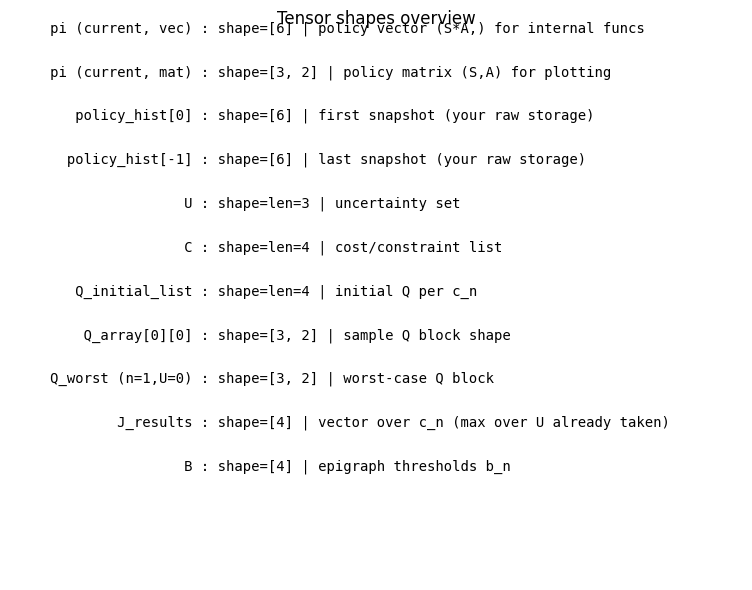

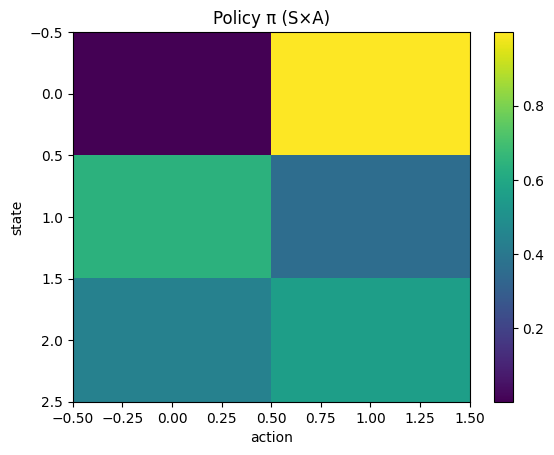

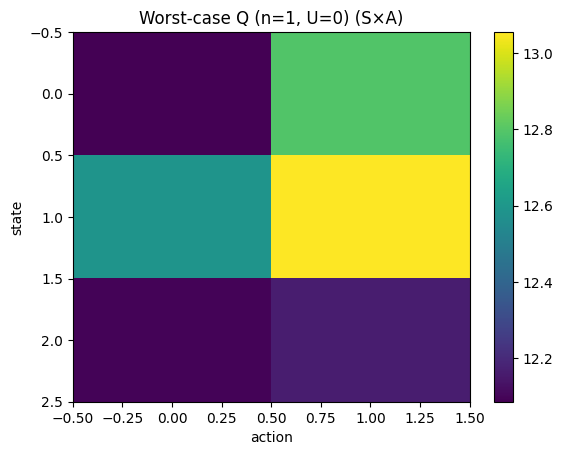

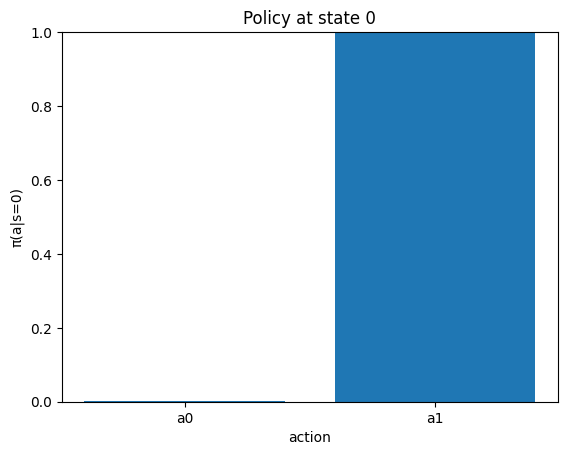

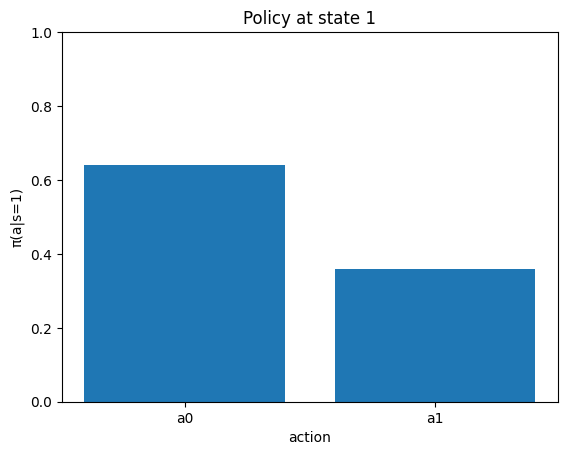

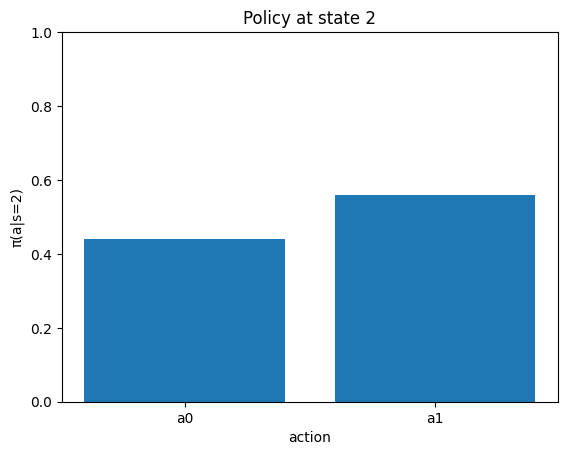

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------- 形状ユーティリティ --------------
def ensure_pi_shapes(pi, S, A):
    """
    入力 pi を、(S*A,) のフラットベクトルと (S,A) の行列の両方に整形して返す。
    内部関数への引数は pi_vec（1D）を使い、可視化は pi_mat（2D）を使う。
    """
    arr = np.asarray(pi)
    if arr.ndim == 1:
        assert arr.size == S * A, f"pi size mismatch: {arr.size} != S*A={S*A}"
        pi_vec = arr.reshape(-1)
        pi_mat = arr.reshape(S, A)
    elif arr.ndim == 2:
        assert arr.shape == (S, A), f"pi shape mismatch: {arr.shape} != ({S},{A})"
        pi_mat = arr
        pi_vec = arr.reshape(-1)
    else:
        raise ValueError(f"Unsupported pi shape: {arr.shape}")
    return pi_vec, pi_mat

def safe_get_Q_worst(Q_array, worst_u, worst_n):
    """
    Q_array の実装差（list/ndarray, 次元）に頑健に対応して
    最悪 (worst_u, worst_n) の Q を (S,A) にして返す。
    期待：Q_array[u][n] または Q_array[u, n] が (S,A) か (S,A,...)。
    """
    Qa = Q_array
    try:
        Q_block = Qa[worst_u][worst_n]
    except Exception:
        Q_block = Qa[worst_u, worst_n]
    Q_block = np.asarray(Q_block)
    if Q_block.ndim > 2:
        # 余計な軸があれば先頭2軸を (S,A) とみなして切り出し（必要なら調整）
        Q_block = Q_block[..., 0]
    return Q_block

# -------------- 形状サマリ --------------
def summarize_shapes(pi, policy_hist, U, C, Q_initial_list, B, S, A, gamma, H):
    """
    ・内部APIにはフラットπ（pi_vec）を渡す
    ・可視化には (S,A)（pi_mat）を使う
    """
    # πの両形状
    pi_vec, pi_mat = ensure_pi_shapes(pi, S, A)

    # Q^π を全Uで計算（←内部関数はフラット想定なので pi_vec を渡す）
    Q_array = compute_Q_pi_for_all_U(C, Q_initial_list, U, pi_vec)

    # J と最悪インデックス（これも内部関数はフラット想定のはず）
    J_results, J_max_index, J_max_index_U = compute_J_c_U_b_and_its_max(
        U, C, Q_initial_list, B, pi_vec
    )

    worst_n = int(J_max_index)
    worst_u = int(J_max_index_U[J_max_index])
    Q_worst = safe_get_Q_worst(Q_array, worst_u, worst_n)

    # 表作成
    rows = []
    rows.append(["pi (current, vec)", list(pi_vec.shape), "policy vector (S*A,) for internal funcs"])
    rows.append(["pi (current, mat)", list(pi_mat.shape), "policy matrix (S,A) for plotting"])

    if len(policy_hist) > 0:
        ph0 = np.asarray(policy_hist[0])
        rows.append(["policy_hist[0]", list(ph0.shape), "first snapshot (your raw storage)"])
        phL = np.asarray(policy_hist[-1])
        rows.append(["policy_hist[-1]", list(phL.shape), "last snapshot (your raw storage)"])

    rows.append(["U", f"len={len(U)}", "uncertainty set"])
    rows.append(["C", f"len={len(C)}", "cost/constraint list"])
    rows.append(["Q_initial_list", f"len={len(Q_initial_list)}", "initial Q per c_n"])

    # Q_array の代表要素の形
    try:
        sample_Q = np.asarray(Q_array[0][0])
    except Exception:
        sample_Q = np.asarray(Q_array[0,0])
    rows.append(["Q_array[0][0]", list(sample_Q.shape), "sample Q block shape"])

    rows.append([f"Q_worst (n={worst_n},U={worst_u})", list(np.asarray(Q_worst).shape), "worst-case Q block"])
    rows.append(["J_results", list(np.asarray(J_results).shape), "vector over c_n (max over U already taken)"])
    rows.append(["B", list(np.asarray(B).shape), "epigraph thresholds b_n"])

    df = pd.DataFrame(rows, columns=["name", "shape", "note"])
    return df, pi_mat, Q_worst, (worst_n, worst_u)

# -------------- 図で一覧（テキストボックス） --------------
def draw_shape_boxes(df_shapes, title="Tensor shapes overview"):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.axis('off')
    y0 = 1.0; dy = 0.08
    for i, row in df_shapes.iterrows():
        txt = f"{row['name']:>20} : shape={row['shape']} | {row['note']}"
        ax.text(0.02, y0 - i*dy, txt, fontsize=10, family="monospace")
    plt.title(title); plt.tight_layout(); plt.show()

# -------------- 行列の可視化（π, Q） --------------
def heatmap_matrix(M, title, xlabel="action", ylabel="state"):
    M = np.asarray(M)
    plt.figure()
    plt.imshow(M, aspect='auto')
    plt.colorbar()
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

# -------------- 方策：状態ごとの棒グラフ --------------
def plot_policy_rows(pi_mat):
    S, A = pi_mat.shape
    x = list(range(A))
    for s in range(S):
        plt.figure()
        plt.bar(x, pi_mat[s])
        plt.ylim(0, 1)
        plt.xticks(x, [f"a{a}" for a in x])
        plt.xlabel("action"); plt.ylabel(f"π(a|s={s})")
        plt.title(f"Policy at state {s}")
        plt.show()

# 形状まとめ & 可視化用データ
df_shapes, pi_mat, Q_worst, (worst_n, worst_u) = summarize_shapes(
    pi=pi, policy_hist=policy_hist, U=U, C=C, Q_initial_list=Q_initial_list, B=B,
    S=S, A=A, gamma=gamma, H=H
)
display(df_shapes)
draw_shape_boxes(df_shapes)

# ヒートマップ
heatmap_matrix(pi_mat, "Policy π (S×A)")
heatmap_matrix(Q_worst, f"Worst-case Q (n={worst_n}, U={worst_u}) (S×A)")

# 方策の棒グラフ（状態ごと）
plot_policy_rows(pi_mat)



## 得られた知見
内側ルーチンでのベルマン方程式の計算は，収束するまで反復的に計算をしている．
* 価値反復法は1反復で1ステップの更新だけ
* 方策反復法は1反復で収束するまで反復更新をする

ホライゾンが1に近いと，収束に時間がかかる＋勾配がめっちゃでかくなる

### 内側ループ
* T回反復する
  * 現在の方策を用いて方策評価を行う
      * 制約ごとに，J_n_U - bnを求める
        * 遷移確率ごとに，J_c_Pを計算する
          * ベルマン方程式を，Qの更新差分が収束するまで繰り返し適用する
        * 最もJ_c_Pが大きなPとJn_Uを求める．
        * J_n_U - bnを求める．
        * 最もJ_n_U - bnが大きくなる制約nを求める
  * 射影勾配法を用いて方策を更新する
    * 方策評価で求めた制約nにおけるJ_n_Uを現在の方策での劣勾配を求める．
      * ∇J_n_U(pi) = H * d_pi * Q (勾配の計算が怪しい)
      * (劣)勾配は方策と同じ次元
    * 方策から勾配を定数倍したものを引く
    * 引いたものを入力とする最適化(最小化)問題を解く
      * 最適化問題を最小化するような方策を求める
  * 方策を更新し，現在の方策とする．
  * 方策は，J_n_U - bnが最も小さくなったtにおける方策とする

### 外側ループ
i =0,j = Hとして初期化
* K回反復する
  * b_0 = (i+j)/2
  * b0を入力として，内側ループで得られた方策を獲得する
  * 得られた方策を用いて，J_n_U -bnの最大値を求める
  * 最大値を用いてiとjを更新する．
    * 最大値が0超過なら iはb0，それ以外ならそのまま
    * 最大値が0超過なら jはそのまま，それ以外ならb0
